In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import vgg16

from IPython.display import Image
import tensorflow as tf

In [2]:
main_folder = 'input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/'
weights_folder = 'weights/'
EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20

## ATTRIBUTE DF

In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.head()

,file_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
df_attr.set_index('file_name', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

## PARTITION DF

In [5]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()
df_partition['val'].value_counts().sort_index()

# join the partition with the attributes
df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'].astype(str), how='inner')
df_par_attr.head()

,val,Male
file_name,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [6]:
# load one image and reshape
img = load_img(EXAMPLE_PIC)
y = img_to_array(img)/255.
x = y.reshape((1,) + y.shape)
  
y.shape

(218, 178, 3)

In [7]:
x.shape

(1, 218, 178, 3)

## Generate Train Dataset

In [8]:
df_train = df_par_attr[(df_par_attr['val'] == 0) & (df_par_attr['Male'] == '0')].sample(TRAINING_SAMPLES//2)
df_train = pd.concat([
    df_train,
    df_par_attr[(df_par_attr['val'] == 0) & (df_par_attr['Male'] == '1')].sample(TRAINING_SAMPLES//2)
])

df_train.reset_index(inplace=True)
df_train

,file_name,val,Male
0,023763.jpg,0,0
1,048864.jpg,0,0
2,052671.jpg,0,0
3,075205.jpg,0,0
4,069761.jpg,0,0
...,...,...,...
9995,078871.jpg,0,1
9996,114707.jpg,0,1
9997,060536.jpg,0,1
9998,159735.jpg,0,1


## Load images from folder

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=images_folder, 
    x_col='file_name', 
    y_col="Male", 
    class_mode="binary", 
    color_mode="rgb",
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 10000 validated image filenames belonging to 2 classes.


## Generate Validation Dataset

In [10]:
df_val = df_par_attr[(df_par_attr['val'] == 1) & (df_par_attr['Male'] == '0')].sample(VALIDATION_SAMPLES//2)
df_val = pd.concat([
    df_val,
    df_par_attr[(df_par_attr['val'] == 1) & (df_par_attr['Male'] == '1')].sample(VALIDATION_SAMPLES//2)
])

df_val.reset_index(inplace=True)
df_val

,file_name,val,Male
0,176498.jpg,1,0
1,175434.jpg,1,0
2,182038.jpg,1,0
3,165115.jpg,1,0
4,175837.jpg,1,0
...,...,...,...
1995,162779.jpg,1,1
1996,168451.jpg,1,1
1997,181864.jpg,1,1
1998,167232.jpg,1,1


In [11]:
val_generator = datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=images_folder, 
    x_col='file_name', 
    y_col="Male", 
    class_mode="binary", 
    color_mode="rgb",
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 2000 validated image filenames belonging to 2 classes.


## Generate Test Dataset

In [12]:
df_test = df_par_attr[(df_par_attr['val'] == 2) & (df_par_attr['Male'] == '0')].sample(TEST_SAMPLES//2)
df_test = pd.concat([
    df_test,
    df_par_attr[(df_par_attr['val'] == 2) & (df_par_attr['Male'] == '1')].sample(TEST_SAMPLES//2)
])

df_test.reset_index(inplace=True)
df_test

,file_name,val,Male
0,190672.jpg,2,0
1,190147.jpg,2,0
2,191864.jpg,2,0
3,188762.jpg,2,0
4,199959.jpg,2,0
...,...,...,...
1995,186254.jpg,2,1
1996,196428.jpg,2,1
1997,201135.jpg,2,1
1998,190688.jpg,2,1


In [13]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory=images_folder, 
    x_col='file_name', 
    y_col="Male", 
    class_mode='binary', 
    color_mode="rgb",
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

Found 2000 validated image filenames belonging to 2 classes.


In [14]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = val_generator.n//val_generator.batch_size

STEP_SIZE_VAL

125

## Model creation

In [15]:
# VGG 16 as base
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

model.fit(
    train_generator,
    steps_per_epoch=TRAINING_SAMPLES//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=STEP_SIZE_VAL,
    callbacks=[es],
    epochs=NUM_EPOCHS,
    verbose=1
)

model.save(weights_folder)

Epoch 1/20
625/625 [==============================] - 68s 101ms/step - loss: 0.3620 - accuracy: 0.8364 - val_loss: 0.2766 - val_accuracy: 0.8815
Epoch 2/20
625/625 [==============================] - 60s 96ms/step - loss: 0.2970 - accuracy: 0.8741 - val_loss: 0.2316 - val_accuracy: 0.9025
Epoch 3/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2728 - accuracy: 0.8838 - val_loss: 0.2189 - val_accuracy: 0.9095
Epoch 4/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2650 - accuracy: 0.8874 - val_loss: 0.2236 - val_accuracy: 0.9085
Epoch 5/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2617 - accuracy: 0.8895 - val_loss: 0.2232 - val_accuracy: 0.9160
Epoch 6/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2508 - accuracy: 0.8946 - val_loss: 0.2101 - val_accuracy: 0.9140
Epoch 7/20
625/625 [==============================] - 59s 95ms/step - loss: 0.2496 - accuracy: 0.8968 - val_loss: 0.2325 - val_accuracy

## Prediction on test set

In [43]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred = model.predict(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

125/125 [==============================] - 9s 75ms/step


In [45]:
#pd.DataFrame(pred, columns=['probability', 'Male'])
male = []

for i in pred:
    if i[0] > 0.5:
        male.append(1)
    else:
        male.append(0)

test_result = pd.DataFrame(pred, columns=['probability'])
test_result['Male'] = male
test_result

,probability,Male
0,0.000336,0
1,0.000015,0
2,0.000232,0
3,0.099500,0
4,0.078525,0
...,...,...
1995,0.862868,1
1996,0.393596,0
1997,0.610015,1
1998,0.601038,1


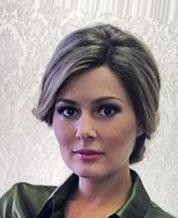

In [49]:
img_file = df_test._get_value(4, 'file_name')
img_file = images_folder + img_file
img_file
img = load_img(img_file)
img

## Custom test set

In [80]:
custom_folder = 'test/'

numpy_array = np.array(
    [['alvin.jpg', '1'],
     ['alvins_chai.jpg', '0'],
     ['buff.jpg', '0'],
     ['buff_2.jpg', '0'],
     ['jolene.jpg', '0'],
     ['jolene_2.jpg', '0'],
     ['ky.jpg', '1'],
     ['ky_fren.jpg', '0'],
     ['yx.jpg', '1']
    ]
)
df_test_2 = pd.DataFrame(numpy_array, columns=['file_name', 'Male'])
# df_test_2.reset_index(inplace=True)

test2_generator = datagen.flow_from_dataframe(
    dataframe=df_test_2, 
    directory=custom_folder, 
    x_col='file_name', 
    y_col="Male", 
    class_mode='binary', 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    shuffle=False,
    seed=42
)

Found 9 validated image filenames belonging to 2 classes.


In [81]:
test2_generator.reset()

pred_custom = model.predict(
    test2_generator,
    verbose=1
)

1/1 [==============================] - 3s 3s/step


In [87]:
numpy_array[0][0]

'alvin.jpg'

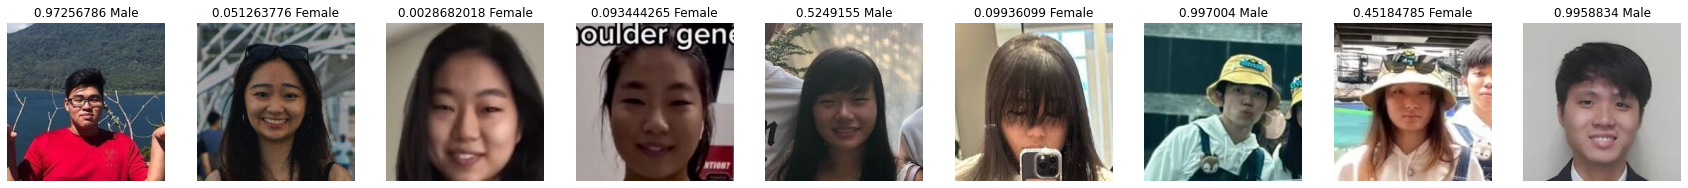

In [94]:
# alvin_img = load_img(custom_folder + 'alvin.jpg')
# alvins_chai_img = load_img(custom_folder + 'alvins_chai.jpg')
# jolene_img = load_img(custom_folder + 'jolene.jpg')
# jolene_2_img = load_img(custom_folder + 'jolene_2.jpg')
# ky = load_img(custom_folder + 'ky.jpg')
# ky_fren = load_img(custom_folder + 'ky_fren.jpg')
# yx_img = load_img(custom_folder + 'yx.jpg')

fig = plt.figure(figsize=(30, 20))

for ind, val in enumerate(numpy_array):
    fig.add_subplot(1, len(numpy_array), ind+1)
    plt.imshow(load_img(custom_folder + val[0]))
    plt.axis('off')
    if pred_custom[ind][0] > 0.5:
        gender = ' Male'
    else:
        gender = ' Female'
    plt.title(str(pred_custom[ind][0]) + gender)  